# Homework 2 (HW2)

---
By the end of this homework we expect you to be able to:
1. Preprocess data and make it amenable to statistical analysis and machine learning models;
2. Train and test out-of-the-box machine learning models in Python;
3. Carry out statistical hypothesis testing;
4. Carry out simple multivariate regression analyses;
5. Use techniques to control for covariates;

---

## Important Dates

- Homework release: Fri 12 Nov 2021
- **Homework due**: Fri 26 Nov 2021, 23:59
- Grade release: Fri 03 Dec 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at *Piccardi Music,* a promising new music label created by a mysterious Italian disc jockey "*Signor Piccardi*". The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

---

## The data

For this homework you will use a dataset of 18,403 music reviews scraped from Pitchfork¹, including relevant metadata such as review author, review date, record release year, review score, and genre, along with the respective album's audio features pulled from Spotify's API. The data consists of the following columns:

| Column   | Description  |
|----------|:-------------|
| `artist`           | The name of the artist who created the album being reviewed. |
| `album`            | The name of the album being reviewed. |
| `recordlabel`      | The name of the record label(s) who published the album. |
| `releaseyear`      | The year that the album was released. |
| `score`            | The score given to the album by the reviewer on a scale of 0.0 to 10.0. |
| `reviewauthor`     | The name of the author who reviewed the album. |
| `genre`            | The genre assigned to the album by Pitchfork. |
| `reviewdate`       | The date that the review was published.  |
| `key` | The estimated overall musical key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 2 = D, and so on) |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether an album is acoustic. 1.0 represents high confidencethat the album is acoustic. |
| `danceability` | How suitable an album is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 is most danceable.
| `energy` | A perceptual measure of intensity and activity, from 0.0 to 1.0, where 1.0 represents high energy. Metal is often high energy. |
| `instrumentalness` | Predicts whether an album contains no vocals, from 0.0 to 1.0. The closer to 1.0, the more likely the album contains no vocals. |
| `liveness` | Detects the presence of an audience, from 0.0 to 1.0. Scores greater than 0.8 indicate a strong likelihood the album is live. |
| `loudness` | The overall loudness of the album in decibels (dB). |
| `speechiness` | Measures the presence of spoken words in an album on a scale from 0.0 to 1.0. Scores higher than 0.66 indicate an album made entirely of spoken words, while scores below 0.33 indicate music and other non-speech-like elements. |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by an album, where values closer to 1.0 indicate more positive sounds. |
| `tempo` | The overall estimated tempo of an album in beats per minute (BPM). |

¹Pinter, Anthony T., et al. "P4KxSpotify: A Dataset of Pitchfork Music Reviews and Spotify Musical Features." Proceedings of the International AAAI Conference on Web and Social Media. Vol. 14. 2020.

#### Imports:

In [47]:
# CHANGE THIS IF YOU NEED/WANT TOO

# pandas / numpy
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# datetime operations
from datetime import datetime

# ttest, euclidean distance and bootstrap
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean
from scipy.stats import bootstrap

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import resample

# displaying markdown strings
from IPython.display import display, Markdown, Latex

#### Constants:

In [48]:
RANDOM_STATE = 123

#### Helper functions:

In [49]:
# Converts nb into (i, j) coordinates in a height*width grid.
def convert_to_grid(nb, height, width):
    return (nb // width, nb%width)    

## Part 1: Will this album be a hit?

The first project you embark on in your new job is to build a regressor to predict whether an album will be well received or not. According to *Signor Piccardi* (your boss), this algorithm may eventually be helpful in forecasting the success of albums produced by *Piccardi Music*.

**Task 1 (Initial analyses — 10 pts)**

As a good data scientist, the first thing you do is to have a good look at the data that was handed to you.

1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

2. Plot the distribution of album release years and the average score of albums per year.

3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

3. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected. 

---

### 1.1 - Load data
1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

* We drop the row with inconsistent data, i.e. data that is out of bounds w.r.t. some feature.
* We drop duplicates reviews as defined above.

In [50]:
#load data
df = pd.read_csv("./data/pitchfork.csv.gz",compression='gzip')

#There are some rows which contain inconsistent data
print(df.loc[(df['danceability'] < 0) | (df['energy'] < 0) | (df['instrumentalness'] < 0) |
             (df['liveness'] < 0) | (df['valence'] < 0) | (df['tempo'] == 0)].count())
print("---")

#Drop rows with inconsistent data
df = df.drop(df[(df['danceability'] < 0) | (df['energy'] < 0) | (df['instrumentalness'] < 0) |
                (df['liveness'] < 0) | (df['valence'] < 0) | (df['tempo'] == 0)].index)

# We observe that the the number of reviews for the same album is very low
# hence we can drop these this rows to keep the analysis simpler 
print("\nThere are " + str((df.groupby(['artist','album']).size()>1).sum()) +
      " albums with more than a review")

#Remove duplicates
df = df.drop_duplicates(subset = ['artist','album'], keep ='first')

print("\nThe number of rows in the dataframe is " + str(len(df.index)))

artist              8
album               8
reviewauthor        8
score               8
releaseyear         8
reviewdate          8
recordlabel         8
genre               8
danceability        8
energy              8
key                 8
loudness            8
speechiness         8
acousticness        8
instrumentalness    8
liveness            8
valence             8
tempo               8
dtype: int64
---

There are 46 albums with more than a review

The number of rows in the dataframe is 16730


### 1.2 - Distributions

2. Plot the distribution of album release years and the average score of albums per year.

We plot the distribution of album release years and the average score of albums per year.

Text(0.5, 1.0, 'Distribution of album average score per year')

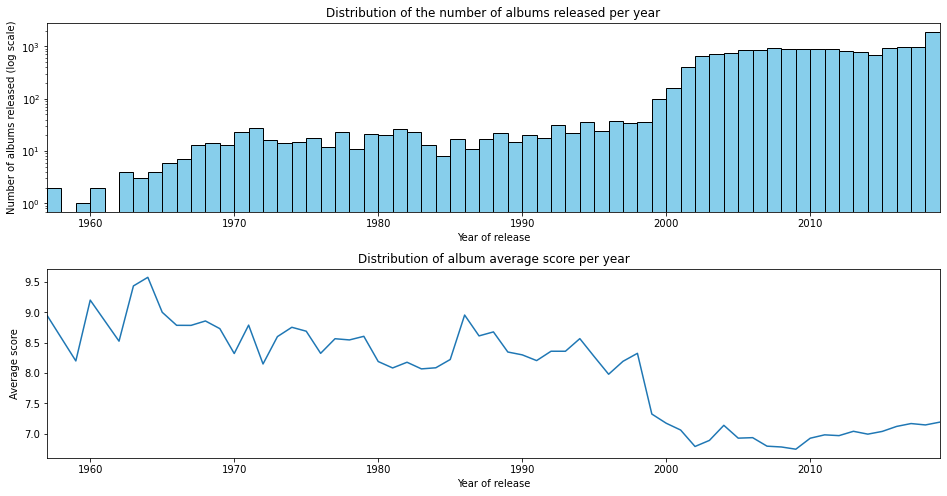

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))
fig.subplots_adjust(hspace=0.3)


#plot number of releases per year
first_year_release = df.releaseyear.min()
last_year_release = df.releaseyear.max()
total_number_of_years_releasing = int(last_year_release - first_year_release)

#Plot distribution of album release years
ax1.hist(df.releaseyear, color = 'skyblue', edgecolor = 'black', bins = total_number_of_years_releasing)
ax1.set_xlim(first_year_release, last_year_release)
ax1.set_yscale("log")

ax1.set_xlabel('Year of release')
ax1.set_ylabel('Number of albums released (log scale)')
ax1.set_title("Distribution of the number of albums released per year")

#Plot average score of albums per year
group_albums_year_mean = df.groupby("releaseyear").mean()
ax2.plot(group_albums_year_mean.score)
ax2.set_xlim(first_year_release, last_year_release)

ax2.set_xlabel('Year of release')
ax2.set_ylabel('Average score')
ax2.set_title("Distribution of album average score per year")

It seems there are more and more albums every year, and that there was a boom around 2000.  
On the other hand, the album's average score has diminished with time, again especially around 2000.  
A reasonable explanation for the duality of these curves may be that with more albums, came more lower quality albums, reducing the average score of these albums.

### 1.3 - Numerical Values
3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

We do some stats on the numerical columns, to get a grasp of the data and look for outliers which should be dropped we might have missed.

In [52]:
# Get numerical columns
df_numeric = df.select_dtypes(include = np.number)

# Get the mean, median, minimum value and maximum value
df_numeric.describe()

,score,releaseyear,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000,16730.000000
mean,7.048536,2009.345965,0.512967,0.601951,5.219034,-9.286912,0.091208,0.302476,0.275303,0.196910,0.405853,120.377216
std,1.247075,7.796655,0.155855,0.200585,1.609184,4.235933,0.087334,0.261090,0.297825,0.102060,0.180055,15.285773
min,0.000000,1957.000000,0.038667,0.000126,0.000000,-51.728750,0.008644,0.000001,0.000000,0.015300,0.000010,23.983333
25%,6.500000,2005.000000,0.409000,0.474182,4.333333,-11.218268,0.040649,0.091222,0.009703,0.134553,0.274400,111.255450
50%,7.300000,2010.000000,0.511364,0.624823,5.230769,-8.446428,0.056681,0.229000,0.149641,0.174304,0.406300,120.406490
75%,7.800000,2015.000000,0.622725,0.749741,6.100000,-6.397199,0.100281,0.460824,0.497569,0.228350,0.531823,129.146312
max,10.000000,2019.000000,0.974000,0.999000,11.000000,4.078000,0.958000,0.996000,0.982000,0.978000,0.971000,215.972000


We plot the distribution for all the numerical columns in a single image of size 14'' by 14'':

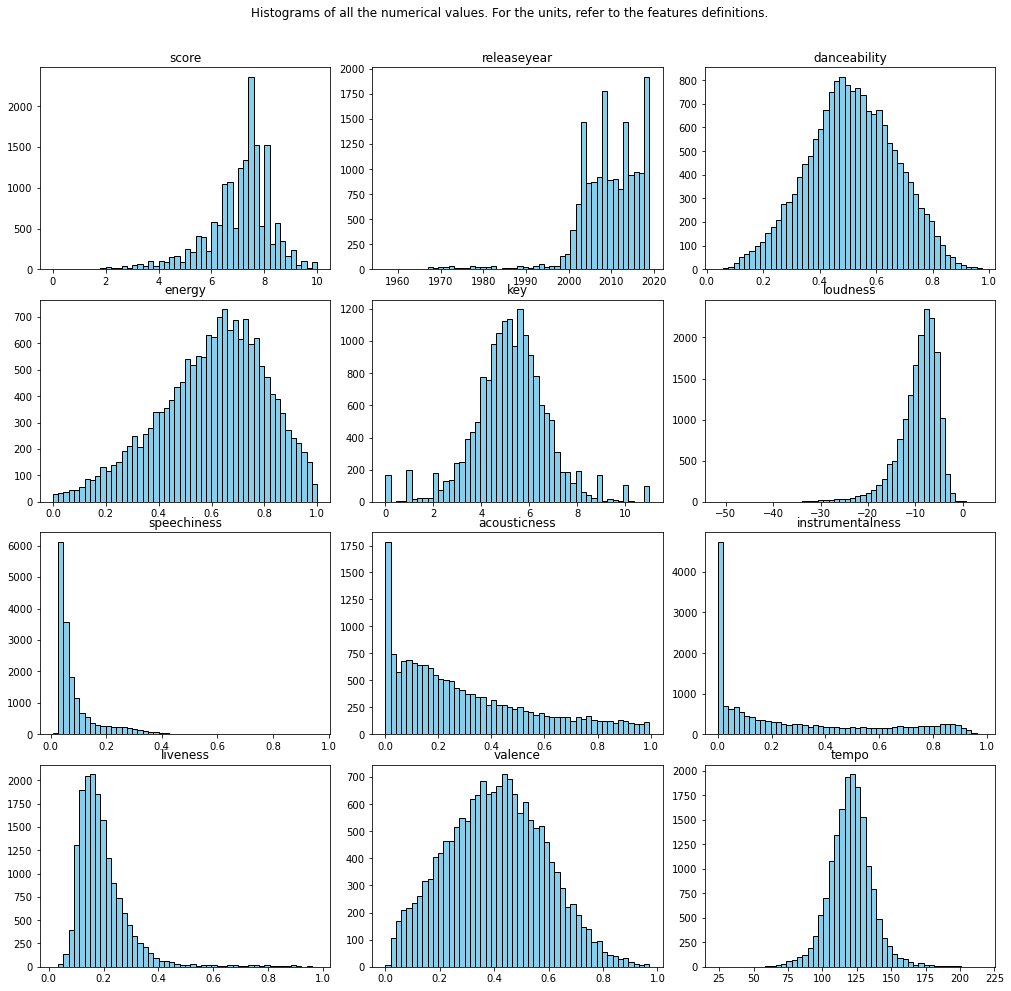

In [53]:
nrows, ncols = 4, 3
fig, axes  = plt.subplots(nrows, ncols, figsize=(14,14))
fig.suptitle('Histograms of all the numerical values. For the units, refer to the features definitions.')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

for n in range(len(df_numeric.columns)):
    col_name = df_numeric.columns[n]
    i, j = convert_to_grid(n, nrows, ncols)
    axes[i, j].hist(df_numeric[col_name], color = 'skyblue', edgecolor = 'black', bins=50)
    axes[i, j].set_title(col_name)

The numerical featurse have various distributions.

### 1.4 - Categorical values
4. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

First we do the replacement: in the `genre` column: if the original value was `'none'` or `NaN`, we assign it to `'Other'`.

In [54]:
#Assign Other to NaN and None
print("The number of genre with NaN is " + str(df.genre.isna().sum()) + 
      ", so there are not any NaN value in rows for genre.")

df.genre = df.genre.replace(to_replace = 'none', value = 'Other')

The number of genre with NaN is 0, so there are not any NaN value in rows for genre.


Then we indicate the number of **distinct values** for each **categorical column**, and print them if possible (i.e. if there are fewer than 10 distinct values).

In [55]:
#Get categorical columns
df_categorical = df.select_dtypes(exclude = np.number)

#Print results
for col in df_categorical.columns:
    print("* There are " + str(df_categorical[col].nunique()) + " different values in column `" + col + "`.")
    if(df_categorical[col].nunique() <= 10):
        print("---> The different values in `" + col + "` are: ")
        print(df_categorical[col].unique())

* There are 7890 different values in column `artist`.
* There are 16176 different values in column `album`.
* There are 554 different values in column `reviewauthor`.
* There are 4876 different values in column `reviewdate`.
* There are 3030 different values in column `recordlabel`.
* There are 10 different values in column `genre`.
---> The different values in `genre` are: 
['Electronic' 'Folk/Country' 'Rock' 'Rap' 'Global' 'Experimental' 'Metal'
 'Pop/R&B' 'Jazz' 'Other']


| Colum name            | Number of different values |
|:--------------------- |:---------------------------|
| artist                | 7890                       |
| album                 | 16177                      |
| reviewauthor          | 554                        |
| reviewdate            | 4876                       |
| recordlabel           | 3030                       |
| genre                 | 10                         |

In the `genre` column, the different values are:
*'Electronic', 'Folk/Country', 'Rock', 'Rap', 'Global',
 'Experimental', 'Metal', 'Pop/R&B', 'Jazz' and 'Other'.*

### 1.5 - Discuss

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected. 

The data may not be representative of music albums in general for diverse reasons. Here are 3:
1. The albums reviewed in pitchfork selected at random among all available albums, but through un andocumented selection process, that is undoubtedly biased, cf [wikipedia, section criticism](https://en.wikipedia.org/wiki/Pitchfork_(website)). This makes it so that a predictor built from this data could only be expected to work well on the subset of all albums from which Pitchfork choose.
2. Even among the albums from pitchfork, a lot were dropped to construct the final dataset. Notably:
    * All those not on spotify or spotify's US library.
    * Albums where the spotify's artists are listed as "Various artists". This implies that collabs/feats between 4 or more artists are sure to be ignored (and this even if they were a hit.    

These bullet points, as explained in *point 1*. increase the bias in the album selection, and hence the appliability of our model.

3. The scores are a *subjective measure* issued by one reviewer ("*The website had a reputation for publishing \[unpredictable reviews\], often strongly dependent on which reviewer was writing.*"). Because of that, there is no guarantee these scores reflect the actual success of an album.

#### **Task 2 (Pre-processing and pipeline code — 12 pts)**

Next, you decide to prepare the code that will help you in training your machine learning models. Also, you implement a simple baseline. For this task, **unless otherwise stated** you must implement functions yourself, instead of relying on `scikit-learn` (you can use `numpy` or `pandas`, though!).

1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0. 

2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

---

### 2.1 - One hot encoding
1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0.

We "transform" the categorical feature `genre` into 10 different binary features.  
To do that we add the new columns to the dataframe, initialized at $0$, then fill them with $1$'s appropriately by iterating on the rows.

In [56]:
#more convenient to code it in this case rather than using pd.get_dummies
# Create the new columns
for genre in df.genre.unique():
    df[genre+"_onehot"] = 0

# Set one hot encoding for appropriate columns
for index, row in df.iterrows():
    df.at[index, row.genre+"_onehot"] = 1

### 2.2 - Create numpy helper 
2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

The following function transforms a datafram into a numpy array containing the selected columns.

In [57]:
# Transforms the dataframe `df` into a numpy array containing the columns 
# indicated by `cols`.
def numpy_helper(df, cols):
    dataset = df[cols]
    return dataset.to_numpy()

### 2.3 - Split the data

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

* First we select the data we're interested in, i.e. the columns corresponding to the features of interest.
* Then we split it into 2 sets: training and testing. The training one will be used to train the model, and the testing one to test it on "new data" (i.e. data we have not interacted with at the time of training).

In [58]:
# Let's keep only the columns we are interested in
columns_onehot = [i for i in df.columns if "onehot" in i]

X = numpy_helper(df, columns_onehot) # genre-related one-hot features
print(f"X: {X.dtype}")
y = df.score # scores
print(f"\ny: {y.dtypes}")

#Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y, train_size = 0.7, test_size = 0.3, random_state = 123)

X: int64

y: float64


Verify the dimensions of the data obtained are as expected:

In [59]:
print(type(X_test_b))

print(f"\n--------------\nshapes:\n")
print(f"X_train: {X_train_b.shape}")
print(f"X_test: {X_test_b.shape}")
print()
print(f"y_train: {y_train_b.shape}")
print(f"y_test: {y_test_b.shape}")

<class 'numpy.ndarray'>

--------------
shapes:

X_train: (11711, 10)
X_test: (5019, 10)

y_train: (11711,)
y_test: (5019,)


### 2.4 - Regressor

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

We implement a baseline regressor, i.e. a very simple one, which will always predict the mean of the scores it was trained with.

In [60]:
# Fit the model by computing the overall avg of the y's (X is basically ignored)
def baseline_fit(X_train, y_train):
    return np.mean(y_train)

# Return a constant column vector
def baseline_predict(X, fit):
    return fit * np.ones(X.shape[0])

### 2.5 - Compute R2

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

In [61]:
fit_b = baseline_fit(X_train_b, y_train_b)
dummy_prediction = baseline_predict(X_test_b, fit_b)
r2 = r2_score(y_test_b, dummy_prediction)

print(f"Training average: {fit_b}")
print(f"r2: {r2}")

Training average: 7.049790794979116
r2: -1.0839329994905e-05


With the dummy prediction model, $r_2 = -1.1*10^{-5}$, which is close to $0$. As expected from a straight line fit.

### 2.6 - Discuss

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?


Here we don't take the full picture of the data, if we only consider 70% we are likely to miss really important informations that are present in the 30% of the data we are going to test our model on. For instance, we split the data let's say of reviews between 1970 and 2020, then if we train only on albums from 1970 to 2005, when we will try to predict the success of an album from 2015 we will not obtain good results because we are never seen this case before. Therefore here what we should do, is do k-old on the data to be sure to train our model on all the data. Furtheremore, we could have trained with data that "bias" or simply the test data is not a reasonable estimation of future albums' success, cf https://www.analyticsvidhya.com/blog/2021/06/unplanned-train-test-split-is-not-always-acceptable/.

**Task 3 (Regression — 14 pts)**

Finally, you get down to business and train your regression models.

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set. 

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

---

### 3.1 - Linear Regression Model

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

Divide the data between training and testing sets:

In [62]:
# Get relevant columns
df_filtered = df.filter(regex='_onehot|^releaseyear|^key|^acousticness|^danceability|^energy|^instrumentalness|^liveness|^loudness|^speechiness|^valence|^tempo')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered.to_numpy(), df.score, train_size = 0.7, test_size = 0.3, random_state=RANDOM_STATE)

Fit a linear prediction model on the chosen features (on the training sets):

In [63]:
# Declare model
lin_model = LinearRegression()

# Train model
lin_model.fit(X_train, y_train)

LinearRegression()

Then use the fitted model to make predictions on the testing set. Notably, output $r_2 = 0.03867$:

In [64]:
# Make predictions
predictions_lin = lin_model.predict(X_test)

# Compute R2
r2 = r2_score(y_test, predictions_lin)
print(f"r2: {r2}")

r2: 0.03866987019280432


Let us display the coefficients and intercept:

In [65]:
print(f"intercept: {lin_model.intercept_}")

coeff_df = pd.DataFrame(lin_model.coef_, df_filtered.columns, columns=['Coefficient'])
coeff_df

intercept: 41.92556808652926


,Coefficient
releaseyear,-0.017459
danceability,-0.368866
energy,0.140699
key,0.003993
loudness,-0.022929
speechiness,0.192225
acousticness,0.061415
instrumentalness,0.228030
liveness,-0.012062
valence,0.105535


Verify the model does use the intercept:

In [66]:
print(f"size: {coeff_df.size}")
print(np.zeros(21).shape)
tmp = np.zeros(21).reshape(1, -1)
print(X_test.shape)
print(tmp.shape)

print(lin_model.predict(tmp))

size: 21
(21,)
(5019, 21)
(1, 21)
[41.92556809]


List some estimated scores VS actual scores for the test data:

In [67]:
actu_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_lin})
actu_vs_pred.head(12)

,Actual,Predicted
5483,7.7,7.219747
7015,7.9,7.139368
9403,7.8,7.400468
13269,7.0,7.149360
12810,5.5,6.908716
7335,7.9,7.067902
3530,7.3,7.070728
9123,7.2,6.762930
2160,6.1,7.046450
10660,9.4,6.942875


From this peek, the model doesn't seem very good (we see several big deviations between the actual and predicted scores). 

### 3.2 - Linear Regression on alternative data

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.


Split the data given the new specifications: 
* The training data corresponds to the albums released before 2000.
* The testing data corresponds to the albums released in 2003 and after.

In [68]:
#Get data before 2000 and after 2003
before_2000_data = df[df["releaseyear"] < 2000]
after_2003_data = df[df["releaseyear"] >= 2003]

#Get relevant data
df_filtered_2000 = before_2000_data.filter(regex='_onehot|^releaseyear|^key|^acousticness|^danceability|^energy|^instrumentalness|^liveness|^loudness|^speechiness|^valence|^tempo|^score')
df_filtered_2003 = after_2003_data.filter(regex='_onehot|^releaseyear|^key|^acousticness|^danceability|^energy|^instrumentalness|^liveness|^loudness|^speechiness|^valence|^tempo|^score')

# Train-test split:
X_train_2000 = df_filtered_2000.drop("score", axis=1)
y_train_2000 = df_filtered_2000.score

X_test_2003 = df_filtered_2003.drop("score", axis=1)
y_test_2003 = df_filtered_2003.score

print(f"training samples: {X_train_2000.shape[0]}")
print(f"testing samples : {X_test_2003.shape[0]}")

dropped_count = df[(df["releaseyear"] >= 2000) & (df["releaseyear"] < 2003)].shape[0]
print(f"dropped sample  : {dropped_count}")

training samples: 778
testing samples : 14744
dropped sample  : 1208


Our training set is quite small.

Declare and train the model, here a simple linear regression:

In [69]:
#Declare model
lin_model = LinearRegression()

#Train model
lin_model.fit(X_train_2000, y_train_2000)

LinearRegression()

Use the model to predict values on the test data:

In [70]:
#Make predictions
# predictions_lin_reg_alternative = lin_model.predict(df_filtered_2003.drop("score",axis=1))
y_pred_2003 = lin_model.predict(X_test_2003)

Print the corresponding R-squared: $R_2 = -0.282$.  
It corresponds to the "fraction of variance explained by the model" 
(i.e. $1 - \frac{\text{variance of residuals}}{\text{data true variance}}$) .  
Here a negative value indicates that, in a sense, the model gives worse prediction than the 'best' constant estimation: the true mean of the data (which to model we would approximate using the mean of the training data, cf 2.4)

In [71]:
#Compute R2
r2_sklearn = r2_score(y_test_2003, y_pred_2003)
print(f"r_2: {r2_sklearn}")

r_2: -0.28225204260641146


List some estimated scores VS actual scores for the test data:

In [72]:
actu_vs_pred = pd.DataFrame({'Actual score': y_test_2003, 'Predicted score': y_pred_2003})
actu_vs_pred.head(12)

,Actual score,Predicted score
0,8.5,7.163518
1,8.2,7.504677
2,8.3,7.509026
3,7.3,7.991936
4,7.5,7.647314
5,7.6,6.983962
6,8.2,7.388423
8,6.9,7.400328
9,7.0,7.226013
12,7.0,7.478424


### 3.3 - Residuals 

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.



We plot the distribution of the residuals for the linear regression in 3.2

Text(0.5, 1.0, 'Distribution of residuals for linear regression (50 bins).')

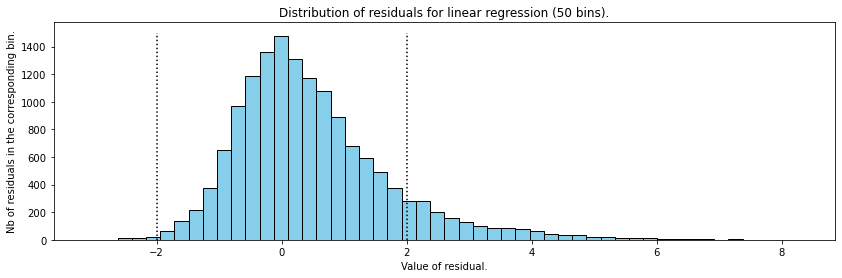

In [73]:
#Compute the residuals
residuals_lin_reg = y_pred_2003 - y_test_2003

# plotting
fig, ax = plt.subplots(1,1, figsize=(14,4))

plt.hist(residuals_lin_reg, bins=50, color = 'skyblue', edgecolor = 'black')

plt.vlines(-2, ymin=0, ymax=1500, colors='black', linestyles='dotted', label='histogram mean')
plt.vlines(+2, ymin=0, ymax=1500, colors='black', linestyles='dotted', label='histogram mean')

plt.xlabel("Value of residual.")
plt.ylabel("Nb of residuals in the corresponding bin.")
plt.title("Distribution of residuals for linear regression (50 bins).")

Here are the functions to compute the desired statistics.
The code is adapted from [here](https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/).

In [74]:
# one-liner
# computes the frequency of residuals deviating from more than the threshold (e.g. 2)
def compute_residual_offset_proba(residuals, threshold=2):
    return residuals[np.abs(residuals) > 2].count() / residuals.count()

# We resample separately on the training and testing datasets:
# percent_samples indicates the size of the samples as a percentage.
def compute_stats_residual_offset(X_test, y_test, n_iterations=200, threshold=2):
    """
    Computes an ordered list of stats, with sampling size of the whole dataset.
    ...

    Attributes
    ----------
    X_test: 
        the original testing features-dataset
    y_test: 
        the original testing scores-dataset
    n_iterations:
        the number of bootstrapping iterations, i.e. of samplings.(default 100)
    threshold:
        the residual deviation we are interested in (default 2)
    """
    
    stats = []
    for i in range (n_iterations):
        # resample
        samples = df_filtered_2003.sample(frac=1, replace=True)
        X_test_s = samples.drop("score", axis=1) # features
        y_test_s = df_filtered_2003.score # scores
        
        # Predict using model
        y_pred_s = lin_model.predict(X_test_s)
        
        # Compute desired stats
        residuals_s = y_pred_s - y_test_s
        stat = compute_residual_offset_proba(residuals_s, threshold)
        
        stats.append(stat)
    
    return np.array(stats)

In [75]:
# With our sampling
print(f"{compute_residual_offset_proba(residuals_lin_reg, 2)*100}%")
stats = compute_stats_residual_offset(X_test_2003, y_test_2003)

10.926478567552902%


95.0% confidence interval 10.59% and 11.02%.


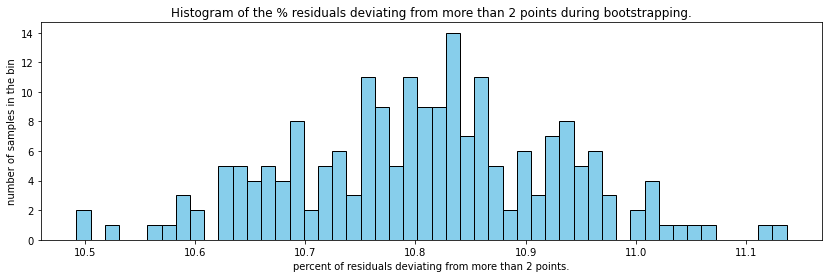

In [76]:
fig, ax = plt.subplots(1,1, figsize=(14,4))

# plot scores
plt.hist(stats*100, bins=50, color = 'skyblue', edgecolor = 'black')
plt.xlabel("percent of residuals deviating from more than 2 points.")
plt.ylabel("number of samples in the bin")

plt.title("Histogram of the % residuals deviating from more than 2 points during bootstrapping.")
# plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print(f"{alpha:.1%} confidence interval {lower:.2%} and {upper:.2%}.")

For our chosen training and testing sets (<2000 and >=2003), there is a 10.9% chance that a residual is off by more than 2 points. 

With bootstrapping we get more general bounds: there is a 95% likelihood that the probability that the residuals is off by 2 points if off by more than 2 points is in the confidence interval **10.6% to 11.0%**. It is therefore upperbounded by 11.1%.

### 3.4 Gradient boosting regressor

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set. 

In [77]:
#Declare gradient boosted model
lin_model = GradientBoostingRegressor()

#Train model
lin_model.fit(X_train_2000, y_train_2000)

#Make predictions
y_pred_boosted = lin_model.predict(X_test_2003)

r2 = -0.40437239063501296
The loss is 1.936711340283124


Text(0.5, 1.0, 'Distribution of residuals for gradient boosted regressor(50 bins).')

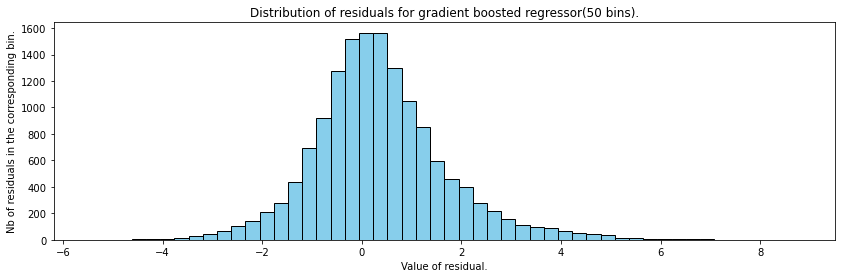

In [105]:
#Compute R2
r2 = r2_score(y_test_2003, y_pred_boosted)
print(f"r2 = {r2}")

#Compute loss
print(f"The loss is {best_lin_reg.loss_(y_test_2003, y_pred_boosted)}")

#Compute the residuals
residuals_boosted = y_pred_boosted - y_test_2003

# plotting
fig, ax = plt.subplots(1,1, figsize=(14,4))

plt.hist(residuals_boosted, bins=50, color = 'skyblue', edgecolor = 'black')

plt.xlabel("Value of residual.")
plt.ylabel("Nb of residuals in the corresponding bin.")
plt.title("Distribution of residuals for gradient boosted regressor(50 bins).")

Plot the 2 models' residuals at the same time to compare them:

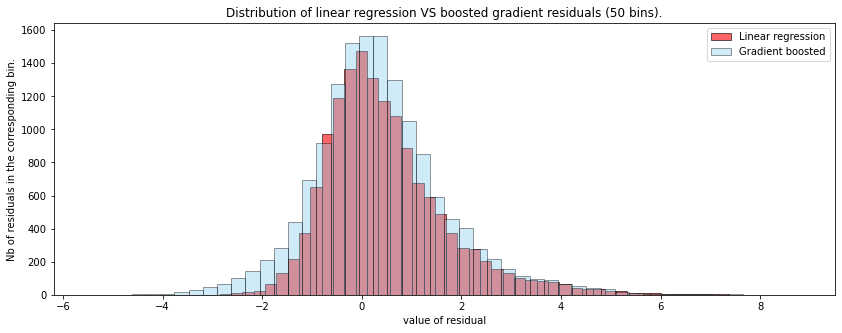

In [79]:
fig, ax = plt.subplots(1,1, figsize=(14,5))

plt.hist(residuals_lin_reg, bins=50, color='r', edgecolor = 'black', alpha=0.6, label='Linear regression')
plt.hist(residuals_boosted, bins=50, color='skyblue', edgecolor = 'black', alpha=0.4, label='Gradient boosted')

plt.xlabel('value of residual')
plt.ylabel('Nb of residuals in the corresponding bin.')
plt.title("Distribution of linear regression VS boosted gradient residuals (50 bins).")

_ = plt.legend()

The graph above shows that the linear regression on the alternative data has better performance than the gradient booster regression (basically all residuals are smaller).

Residuals for dummy regressor VS boosted gradient  
Given that r2 is highly negative, we should expect the dummy regressor to be 'better', but with more "outliers", i.e. big residuals in absolute value:

8.287017994858612


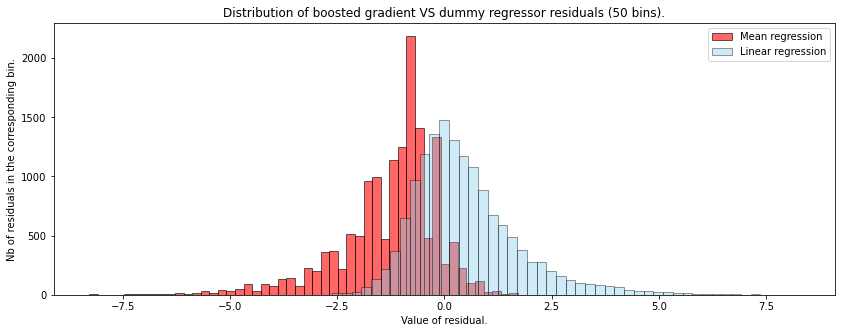

In [80]:
print(y_train_2000.mean())
residuals_dummy = y_test_2003 - y_train_2000.mean()

fig, ax = plt.subplots(1,1, figsize=(14,5))

plt.hist(residuals_dummy, bins=50, color='r', edgecolor = 'black', alpha=0.6, label='Mean regression')
plt.hist(residuals_lin_reg, bins=50, color='skyblue', edgecolor = 'black', alpha=0.4, label='Linear regression')

plt.xlabel("Value of residual.")
plt.ylabel("Nb of residuals in the corresponding bin.")
plt.title("Distribution of boosted gradient VS dummy regressor residuals (50 bins).")

_ = plt.legend()

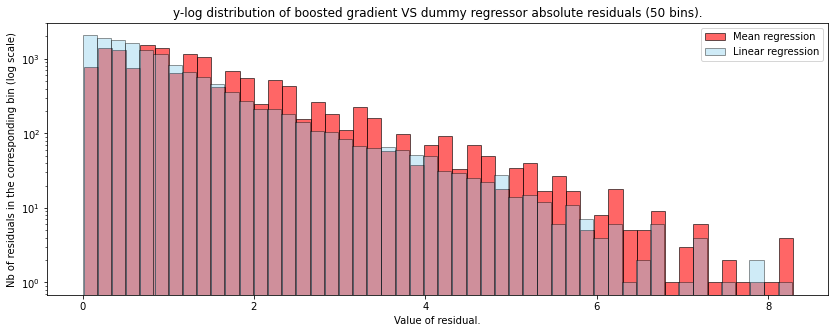

In [81]:
fig, ax = plt.subplots(1,1, figsize=(14,5))

plt.hist(np.abs(residuals_dummy), bins=50, color='r', edgecolor = 'black', alpha=0.6, label='Mean regression')
plt.hist(
    np.abs(residuals_lin_reg), bins=50, color='skyblue', edgecolor = 'black', alpha=0.4, label='Linear regression')

plt.yscale('log')

plt.xlabel("Value of residual.")
plt.ylabel("Nb of residuals in the corresponding bin (log scale)")
plt.title("y-log distribution of boosted gradient VS dummy regressor absolute residuals (50 bins).")

_ = plt.legend()

It is not obvious from the residual plots whether one approach is overall better than the other (which speaks to the failure of the 'clever' regressions).  
What we *can* say on the other hand is that, for the gradient-boosted regression the error on the score comes more from the lower residuals (in absolute value), compared to the dummy(mean)-regression.

---
In general we have seen that the $R_2$ values were really small, and that the regessors did not fit the data very well.
There are many reasons why that could be the case. Among others, the hypotheses for linear regression (for the linear regression models) are not verified. Notably:
* Not all relevant predictors (or predictor values) are included, e.g. we are missing many genres.
* Score is linear in the predictors: 
    * given the shapes of certain distributions, such as the heavy-tailed speechiness or acousticness it would probably be a good idea to modify the predictors by applying some transformations, e.g. a logarithmic transformation on the aformentioned heavy-tailed ones.
    * We have not accounted for interactions between the predictors, which are bound to happen, between for example tempo and the danceability, or the genre and the tempo.

### 3.5 - Discuss

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

One hypothesis for the difference in performance between the linear regression and the gradient boosting regressor is the data on which they are trained on. The linear regression is trained on a random split, therefore is has evenly-handed sample from all the dataset. On the other hand, the gradient boosting regressor is only trained on sample before 2000, therefore when it needs to predicts the test data which only occurs after 2000 it does poorly his job because we does not predict well unfamiliar data.

An example of this can be seen in [gradient boosted regressor extrapolates badly for features outside of the training range](http://freerangestats.info/blog/2016/12/10/extrapolation). E.g. here the feature `releaseyear` for the training and testing datasets don't overlap.

**Task 4 (Are we solving the correct problem? — 16 pts)**

All your efforts so far have assumed that decisions are taken at the "album" level, which is often not the case for bands with multiple albums. In those cases, it could be interesting to predict what is the success of a given band album given the features of the album **and of previous albums**.

1. Create a new dataframe that contains one row per ~~band~~ artist with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective ~~band~~ artist (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set. 

3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario. 
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.
 
 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.
 
4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

---

https://ada2021epfl.zulipchat.com/#narrow/stream/302231-Homework/topic/.E2.9C.94.20H2.3A.20Task.204.2E1

### 4.1 - New dataframe

1. Create a new dataframe that contains one row per ~~band~~ artist with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective ~~band~~ artist (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

In [82]:
# Create index to merge afterwards
df['index'] = range(1, len(df)+1)

In [83]:
# Create sorted array
df_sorted = df.sort_values("releaseyear")
# Keep only the last album
last_album = df.drop_duplicates(subset = ['artist'], keep ='last')

In [84]:
# Drop last album of artist rows
removed_last_album = df.drop(last_album.index)
# Group by artists to get means
removed_last_album_means = removed_last_album.groupby("artist").mean()
# Get columns of interest
removed_last_album_means = removed_last_album_means.filter(regex='_onehot|^releaseyear|^key|^acousticness|^danceability|^energy|^instrumentalness|^liveness|^loudness|^speechiness|^valence|^tempo')
# Merge on artist
new_dataframe = pd.merge(removed_last_album_means,last_album, on='artist')
# Rename columns
for name in new_dataframe.columns:
    if "_x" in name:
        new_dataframe = new_dataframe.rename(columns={name:name.replace("_x","_previous")})
    else:
        new_dataframe = new_dataframe.rename(columns={name:name.replace("_y","")})

In [85]:
new_dataframe.score

0       7.2
1       8.6
2       8.7
3       7.5
4       6.0
       ... 
3556    6.7
3557    6.2
3558    7.9
3559    7.2
3560    4.5
Name: score, Length: 3561, dtype: float64

In [86]:
#Number of rows
print(f"The number of rows in the dataframe is {len(new_dataframe)} \n")
#Column names
print(new_dataframe.columns)

The number of rows in the dataframe is 3561 

Index(['artist', 'releaseyear_previous', 'danceability_previous',
       'energy_previous', 'key_previous', 'loudness_previous',
       'speechiness_previous', 'acousticness_previous',
       'instrumentalness_previous', 'liveness_previous', 'valence_previous',
       'tempo_previous', 'Electronic_onehot_previous',
       'Folk/Country_onehot_previous', 'Rock_onehot_previous',
       'Rap_onehot_previous', 'Global_onehot_previous',
       'Experimental_onehot_previous', 'Metal_onehot_previous',
       'Pop/R&B_onehot_previous', 'Jazz_onehot_previous',
       'Other_onehot_previous', 'album', 'reviewauthor', 'score',
       'releaseyear', 'reviewdate', 'recordlabel', 'genre', 'danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'Electronic_onehot',
       'Folk/Country_onehot', 'Rock_onehot', 'Rap_onehot', 'Global_onehot',
       'Experimental_onehot', '

### 4.2 - Train a Gradient Boosted regressor on the new dataframe

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set. 

In [87]:
#Data
new_dataframe = new_dataframe.filter(regex='_previous|^score')

#Declare gradient boosted model
lin_model_ndf = GradientBoostingRegressor()

#Split data
X_train_ndf, X_test_ndf, y_train_ndf, y_test_ndf = train_test_split(
    new_dataframe.drop('score',axis=1), new_dataframe.score, train_size = 0.7, test_size = 0.3, 
    random_state=RANDOM_STATE)

#Train model
lin_model_ndf.fit(X_train_ndf,y_train_ndf)
                                                                    
#Make predictions
predictions_ndf = lin_model_ndf.predict(X_test_ndf)

In [88]:
#Compute R2
r2_ndf = r2_score(y_test_ndf, predictions_ndf)
print(f"r2 = {r2_ndf}")

r2 = 0.021926612752532715


### 4.3 - Cross-validation


3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario. 
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.
 
 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.

In [89]:
#implement cross_validation
def cross_validation(y, x, k_fold, seed):
    """
    Performs cross validation on data given parameters, model type, and seed
    :param y: labels
    :param x: input data
    :param k_fold: number of folds for cross validation
    :param seed: integer seed
    """

    k_indices = build_k_indices(y, k_fold, seed)
    
    r2_squares = np.array([[]])
   
    confidence_intervals = np.array([[]])
    
    for estimator_ in [100, 200, 300, 400]:
        print(f"\n>>> iteration estimator_ = {estimator_} ...")
        for l in [0.1, 0.05, 0.01]:                                                            
            print(f"   >>> iteration l = {l} ...")
            r2_scenario = np.empty((3,1))
            
            for k in range(k_fold): 
                train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
                test_indices = k_indices[k]
                x_test  = x[test_indices]
                x_train = x[train_indices]
                y_test  = y[test_indices]
                y_train = y[train_indices]

                # init regressor and fit
                lin_reg_kfold = GradientBoostingRegressor(n_estimators=estimator_, learning_rate=l)
                lin_reg_kfold.fit(x_train,y_train)
                
                # predict
                predictions = lin_reg_kfold.predict(x_test)
                
                # compute R-squared
                r2_scenario = np.append(r2_scenario, r2_score(y_test, predictions))
            
            r2_mean = r2_scenario.mean()
            r2_std = r2_scenario.std()
            
            ci_up   = r2_mean + r2_std*1.645/np.sqrt(len(r2_scenario))
            ci_down = r2_mean - r2_std*1.645/np.sqrt(len(r2_scenario))
            
            confidence_intervals = np.append(confidence_intervals, ci_down)
            confidence_intervals = np.append(confidence_intervals, ci_up)
                        
            r2_squares = np.append(r2_squares, r2_mean)
        
    return r2_squares, confidence_intervals
        
#Build indices for k-fold
def build_k_indices(y, k_fold, seed):
    """
    build k indices for k-fold
    :param y: labels
    :param k_fold: number of folds
    :param seed: random seed value
    :return: array of indices 
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


In [95]:
r2s, ci = cross_validation(y_train_ndf.to_numpy(), X_train_ndf.to_numpy(), 20, 0)


>>> iteration estimator_ = 100 ...
   >>> iteration l = 0.1 ...
   >>> iteration l = 0.05 ...
   >>> iteration l = 0.01 ...

>>> iteration estimator_ = 200 ...
   >>> iteration l = 0.1 ...
   >>> iteration l = 0.05 ...
   >>> iteration l = 0.01 ...

>>> iteration estimator_ = 300 ...
   >>> iteration l = 0.1 ...
   >>> iteration l = 0.05 ...
   >>> iteration l = 0.01 ...

>>> iteration estimator_ = 400 ...
   >>> iteration l = 0.1 ...
   >>> iteration l = 0.05 ...
   >>> iteration l = 0.01 ...


In [96]:
estimators = [100, 200, 300, 400]
learning_parameters = [0.1, 0.05, 0.01]
for i in range(len(estimators)):
        for j in range(len(learning_parameters)):
            print(f"For the n_estimator {estimators[i]} and the learning parameter {learning_parameters[j]} the gradient boosting regressor has a r2 of {r2s[i*3+j]} with the confidence interval of [{ci[i*6+j*2]},{ci[i*6+j*2+1]}]\n")

For the n_estimator 100 and the learning parameter 0.1 the gradient boosting regressor has a r2 of -0.01830755840596069 with the confidence interval of [-0.039946344609375635,0.0033312277974542545]

For the n_estimator 100 and the learning parameter 0.05 the gradient boosting regressor has a r2 of -0.0014472638087865467 with the confidence interval of [-0.018154733228379683,0.01526020561080659]

For the n_estimator 100 and the learning parameter 0.01 the gradient boosting regressor has a r2 of -0.0013407279360870133 with the confidence interval of [-0.00950184453707226,0.006820388664898234]

For the n_estimator 200 and the learning parameter 0.1 the gradient boosting regressor has a r2 of -0.043721389078269376 with the confidence interval of [-0.07098556448986985,-0.016457213666668895]

For the n_estimator 200 and the learning parameter 0.05 the gradient boosting regressor has a r2 of -0.015480372641463623 with the confidence interval of [-0.037020541816894154,0.006059796533966906]

Fo

In [106]:
#The best r2 index
max_r2_index = np.argmax(r2s)

#get index of parameters
i = int(max_r2_index/3)
j = max_r2_index%3

#best params
best_estimator = estimators[i]
best_learning_parameter = learning_parameters[j]

#Declare the model
best_lin_reg = GradientBoostingRegressor(n_estimators=best_estimator, learning_rate=best_learning_parameter)

#Train the model
best_lin_reg.fit(X_train_ndf, y_train_ndf)

#Make predictions
redictions_ndf = best_lin_reg.predict(X_test_ndf)

#Compute the r2
print(f"The r2 score is {r2_score(y_test_ndf, redictions_ndf)}")

#Compute loss
print(f"The loss is {best_lin_reg.loss_(y_test_ndf,redictions_ndf)}")

The r2 score is 0.034268437873867574
The loss is 1.440210386511002


### 4.4 - Discuss

4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

We see that the model in 4.3 performs better than in 3.4 for the r2_score as it is higher, it also has a lower loss.

It is hard to compare the results because:<br>
       -The gradient boosting regressor is not trained on the same data, in the 3.4 we train on the longitudinal split, whereas in the the 4.3 we train by doing a k-fold of the data. In this case, it seems that the models best performs when we do a random split wether thank the longitudinal split.<br>
       -In the 4.3 we seek the best parameters for the model, so it is likely that is has better results at the time of predicting the results. Indeed in the task 3.4, we didn't do a cross-validation to get the best parameters for that situation.

To compare fairly these two different setups we could do the following:

* One way to compare the setups, would be for the task 4.1 to make the mean of features of albums of an artist before a date, and then having the score of the last album past that date. In that case we could tell how well the two models predict data that they have never encounter before.

* In the 3.4 we should also seek the best parameters for the data.

## Part 2: Second Album Syndrome

Your second project at *Piccardi Music* is to shed light on one of the business's oldest enigmas: the "second album syndrome." In a nutshell, the "second album syndrome" is a theory that states that the second album of a band always sucks. ([Related read](https://tvtropes.org/pmwiki/pmwiki.php/Main/SophomoreSlump))

Assume—for the purpose of this task—that the Pitchfork data contains all albums for all artists it covers (even though this might not be true in reality).

**Task 5 (Preliminary analyses — 8 pts)**

You begin by carrying out some preliminary data processing and analyses.

1. Create a new dataframe (from the original data with duplicates dropped, the same as you obtained after finishing Task 1.1) containing only albums from artists with two or more albums and where the release year is not empty.
2. Create a new column `album_number` which indicates how many albums the artist has produced before this one (before the second album, the artist has already produced one album).
3. Calculate the mean and the standard error fo the mean of the scores of the first and second albums in the dataset. Additionally, plot the two distributions. 
4. Use an appropriate method to determine if the difference in means of 1st and 2nd albums is statistically significant?
5. **Discuss:** Do these analyses suggest that the "second album syndrome" exists?

---

to check: https://ada2021epfl.zulipchat.com/#narrow/stream/302231-Homework/topic/.E2.9C.94.20H2.3A.20Task.205.2E2

In [62]:
def print_t_test(x, y, x_name, y_name):
    start_string = f'\nThe average score difference between the {x_name} and the {y_name} is'
    statistic, p_value = ttest_ind(x,y,equal_var=False)
    
    print(f'{start_string} significant \n with a p-value of {p_value:.3e}' if(p_value<0.05) 
      else f'{start_string} not significant \n with a p-value of {p_value:.3e}')

##### 1. Create albums dataframe

We first drop albums with empty releaseyear. Then we create a set of artist with multiple albums. Finally we split the data: one for artists with a single album, one for artists with multiple albums.

In [63]:
df = df[df['releaseyear'].notna()] #Remove empty releaseyear
print(f"There is a total of {len(df)} albums")

#Only keep unique tuples of (artist,album)
df_album_artist = df[['artist','album']].drop_duplicates(ignore_index=False)
#Count how many albums each artists has
df_artist_album_count = df_album_artist.groupby(['artist']).size()
multiple_album_artists = set(df_artist_album_count[df_artist_album_count>1].keys())

df_mult_albums = df[df['artist'].isin(multiple_album_artists)]
df_single_album = df[~df['artist'].isin(multiple_album_artists)]

print(f"There is a total of {len(df_mult_albums)} albums from artist who produced multiple albums")

There is a total of 16730 albums
There is a total of 12401 albums from artist who produced multiple albums


#### 2.Create a new column album_number

We sort albums by their release year, then group the albums by artist (which preserve the relase date order). We create a (artist - album - number of album) dataframe from the group by (the index in the group equals the number of previous album(s)). Then we merge the previously created dataframe with the one of multiple album to augment it with the album number.

In [64]:
df_grouped = df_mult_albums.sort_values(['releaseyear'],ascending=True).groupby('artist')

df_album_index = pd.DataFrame(columns=['artist','album','album_number'])


for artist,cols in df_grouped:
    for index,album in enumerate(cols['album']):
        df_album_index.loc[len(df_album_index.index)] = [artist,album,index]

In [65]:
df_mult_albums = df_mult_albums.merge(df_album_index,on=['artist','album'])
df_mult_albums.sort_values(['artist','releaseyear'])[['artist','album','releaseyear','album_number']]

,artist,album,releaseyear,album_number
5474,!!!,Split EP,1999.0,0
5085,!!!,Louden Up Now,2004.0,1
7824,!!!,Myth Takes,2007.0,2
7467,!!!,"Strange Weather, Isn't It?",2010.0,3
1789,!!!,Thr!!!er,2013.0,4
...,...,...,...,...
154,Âme,Dream House,2018.0,1
5733,Ólafur Arnalds,Found Songs,2009.0,0
1866,Ólafur Arnalds,...And They Have Escaped the Weight of Darkness,2010.0,1
11870,Ólafur Arnalds,Living Room Songs,2012.0,2


#### 3. Mean and the standard error for the mean of the scores of the first and second albums

In [66]:
first_album_scores = df_mult_albums[df_mult_albums['album_number']==0]['score']
second_album_scores = df_mult_albums[df_mult_albums['album_number']==1]['score']

print(f'The mean score for first albums is {first_album_scores.mean():.3f}')
print(f'The standard deviation of the score for first albums is {first_album_scores.std():.3f}')

print(f'The mean score for second albums is {second_album_scores.mean():.3f}')
print(f'The standard deviation score for second albums is {second_album_scores.std():.3f}')

The mean score for first albums is 7.304
The standard deviation of the score for first albums is 1.241
The mean score for second albums is 7.040
The standard deviation score for second albums is 1.265


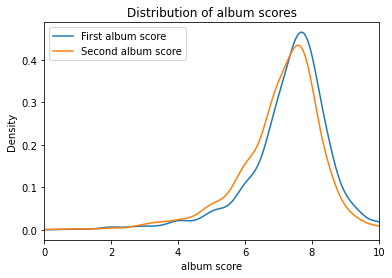

In [75]:
first_album_scores.plot.kde(label='First album score')
second_album_scores.plot.kde(label='Second album score')
plt.xlim([0,10])
plt.xlabel("Album score")
plt.title('Distribution of album scores')
plt.legend()
plt.plot()
pass

#### 4. Is the difference in means of 1st and 2nd albums statistically significant?

To determine if the difference in means is significant, we use a two-sided t-test where the null hypothesis is that the average of the first album score is equal to the average of the second album score. We will also specify to the model that the variance of the two distributions may not be equal. We will reject the null hypothesis with a confidence of 95% (if the p-value is below 0.05 due to having a two-sided test).

In [68]:
print_t_test(first_album_scores,second_album_scores,'first album','second album')


The average score difference between the first album and the second album is significant 
 with a p-value of 8.072e-19


#### 5. Do these analyses suggest that the "second album syndrome" exists?

As we have seen, the mean score for the first album is significantly higher than the mean score for the second album. This average score difference of 0.258 suggest that the second album syndrome exists.

**Task 6 (Regression analysis — 20 pts)**

Next, you proceed to examine some hypotheses about the "second album syndrome" using a regression framework. Namely:

- The **time spent hypothesis:**  the first album usually has a couple of years of development under its belt and plenty of trial and error from live concerts to help the band determine what does or doesn't work. The second album, on the other hand, is often made in a rush.

- The **style change hypothesis:** bands often try to change their style after their first album. This change is not always welcomed by the listeners.

1. Create a new dataframe containing one row per 1st-2nd album pair. The dataframe should contain rows:
    - `score_diff`: the difference in scores between the second and the first album (second - first).
    - `time_diff`: the number of days elapsed between the first and the second album.
    - `did_style_change`: a dummy variable that indicates whether the style of the music has changed. To obtain it, first, calculate the [standardized euclidean distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html) of music-related numerical features¹ between the second and the first album. Second, assign 1 to the 20% most distant 1st-2nd album pairs and 0 to all others.
2. Fit a linear regression using `statsmodels` with this dataframe. Your regression should consider only an intercept, i.e., `"score_diff ~ 1"`.
3. **Discuss:** Interpret the $R^2$ in your regression here. Does this analysis confirm what you observed in Task 5? Why?
4. Include the `time_diff` and `did_style_change` as covariates in your model. Fit the regression again and report the summary of your model. 
5. **Discuss:** Interpret the coefficients `time_diff` and `did_style_change`. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?
6. Create a new column called `time_diff_standardized`. It should be a standardized version of the `time_diff` column. Repeat the regression done in 6.4 using the `time_diff_standardized` column instead of the `time_diff` column.
7. **Discuss:** Explain how the interpretation of the coefficients associated with this new column `time_diff_standardized` differ from its non-standardized version 
`time_diff`?

--- 

**¹** Music related numerical features are:  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", and "tempo".


##### 1 - DF creation

We first create two sub dataframe, one with all albums 0 and one with all albums 1. Then join them together to create pair album 0 - album 1 per artist.

In [69]:
# Create 2 dataframes one with album n0 and one with album n1
albums_0 = df_mult_albums[df_mult_albums["album_number"] == 0]
albums_1 = df_mult_albums[df_mult_albums["album_number"] == 1]

# Join both dataframes by artist, all attributes of album n0/n1 end with _0/_1
pair_albums = albums_0.join(albums_1.set_index("artist"), on=["artist"], lsuffix="_0", rsuffix="_1")

Then based on the attributes of those pairs we create the new requested attributes in a new dataframe. No suprise for *score_diff* and *time_diff*.

In [70]:
df_pair_album_1_2 = pd.DataFrame()

# Create feature of difference of score
df_pair_album_1_2["score_diff"] = pair_albums["score_1"] - pair_albums["score_0"]

# Create feature of diffrence of year
df_pair_album_1_2["time_diff"] = pair_albums["releaseyear_1"] - pair_albums["releaseyear_0"]

For *did_style_change*, we first have to extract the music related numerical features of each album, compute the distance for each pair, based on those attributes. Then set the top 20% greatest distance to one to indicate a change in style.

In [71]:
# Select all music related numerical features
music_related_features = ["key", "acousticness", "danceability", "energy", "instrumentalness",
                          "liveness", "loudness", "speechiness", "valence", "tempo"]

# Add suffix
music_related_features_0 = [s + "_0" for s in music_related_features]
music_related_features_1 = [s + "_1" for s in music_related_features]
variance = np.array(df_mult_albums[music_related_features].var(axis=0)).reshape(1,-1)

# Compute distance of style bewteen albums 0 and 1
def compute_distance(row, variance):
    return seuclidean(row[music_related_features_1], row[music_related_features_0], variance)

pair_albums["distance"] = pair_albums.apply(lambda row: compute_distance(row, variance), axis=1)
quantile_80 = pair_albums["distance"].quantile(0.8)

# Set did_style_change to 1 for the top 20% greatest distance
df_pair_album_1_2["did_style_change"] = np.where(pair_albums["distance"] > quantile_80, 1 , 0)

df_pair_album_1_2

,score_diff,time_diff,did_style_change
1,-0.5,1.0,0
4,-0.5,3.0,1
5,-1.9,3.0,0
7,-1.0,20.0,0
8,-1.2,2.0,0
...,...,...,...
12233,0.0,0.0,1
12273,1.4,2.0,0
12305,-1.9,2.0,0
12316,0.8,1.0,0


##### 2 - Linear regression with constant

We train a basic least square linear regression using only a bias term as input.

In [72]:
res = smf.ols(formula='score_diff ~ 1', data=df_pair_album_1_2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                nan
Time:                        18:12:56   Log-Likelihood:                -6198.9
No. Observations:                3561   AIC:                         1.240e+04
Df Residuals:                    3560   BIC:                         1.241e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2638      0.023    -11.409      0.0

##### 3 - Discussion $R^2$

$R^2 = 1 - var(Re)/ var(Y)$ where $Re = Y - \tilde{X}\hat{B}$ is the residual error matrix. In our case, since we are only fitting the bias term, $Re = Y - C$ where $C$ is a constant vector. Therefore $var(Re) = var(Y)$ thus $R^2 = 0$

We have an intercept of -0.2579 and since the model is based on one intercept it is equivalent to the mean of score_diff, which confirms the diffrence of means computed in task 5. 

##### 4 - Linear regression with time_diff and did_style_change

We train add covariates: continuous *time_diff* and categorical *did_style_change* to our linear regression.

In [73]:
res = smf.ols(formula='score_diff ~ time_diff + C(did_style_change)', data=df_pair_album_1_2).fit()
print(res.summary())
print()
print("Detailed p-values: ")
print(res.pvalues )

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     31.55
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           2.61e-14
Time:                        18:12:56   Log-Likelihood:                -6167.6
No. Observations:                3561   AIC:                         1.234e+04
Df Residuals:                    3558   BIC:                         1.236e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

##### 5 - Discussion linear regression with time_diff and did_style_change

The coefficients of *time_diff* and *did_style_change* would tend to indicate that both a change of style and long period between the albums negatively influences the score of the second album. 

However with a p-value of 0.989, we can not reject the hypothesis that a change in style does not influence the score difference. Morever the near 0 intercept and 0 centered confidence interval would suggest that no correlation between a change in style and the score difference exists. 

Concerning the time difference we are confident (with a p-value < 0.05) that a longer periode between albums  negatively influences the score of the second album.

Since both parameters do not perfectly predict the score difference ($R^2 \ne 1$), this does not exclude any other reasons.

##### 6 - Linear regression with time_diff_standardized and did_style_change

We once again train our linear regression, this time using *time_diff_standardized* instead of *time_diff*. To create *time_diff_standardized* we simply substract the mean and divide by the standard deviation of all the samples.

In [74]:
df_pair_album_1_2["time_diff_standardized"] = 
    (df_pair_album_1_2["time_diff"] - df_pair_album_1_2["time_diff"].mean())/ df_pair_album_1_2["time_diff"].std()

res = smf.ols(formula='score_diff ~ time_diff_standardized + C(did_style_change)', data=df_pair_album_1_2).fit()
print(res.summary())
print()
print("Detailed p-values: ")
print(res.pvalues )

SyntaxError: invalid syntax (Temp/ipykernel_19100/618948246.py, line 1)

##### 7 - Discussion time_diff_standardized and time_diff

It's a good practice to standardize the features. Hence, it's easier to interpret the coefficient of standardized features. Indeed the coefficient directly indicates how a difference from the mean influences the prediction without having to take into account the scaling range of values of the feature.

Coefs without standardization:  
intercept: -0.1361  
time_diff: -0.0338 

Coefs with *time_diff* standardized:    
intercept: -0.2577  
time_diff_standardized: -0.1888  

(In the following explanation we will ignore *did_style_change* feature since it does not much impact on our model).
We can see that the intercept in the standardized case is almost equal to the one obtained in previous steps (task 5.3, 6.2). This due to the fact that *time_diff_standardized* is centred. Finally, the coefficient directly tells us what is the effect of a deviation of one standard deviation from the mean.

**Task 7 (Sanity checks — 6 pts)**

You decide to perform a few last sanity checks for your analysis.

1.  **Discuss:** If the Second Album Syndrome existed, i.e., something was special about the second album (as in if it was bad for a very particular reason that afflicted album number 2 more than all others), what would you expect to happen to the mean score of the third album?
2. Using the dataset you created in Task 5, calculate the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums. Test whether the difference between the average score of the second and the third album is statistically significant.
3. **Discuss:** Does this suggest that the Second Album Syndrome exists?

---


#### 1.Discuss the mean score of the third album assuming Second Album Syndrome

If the Second Album Syndrome existed (album number 2 was bad for a very particular reason that afflicted it number 2 more than all others) we would expect the mean score of the third album to be higher than the second. This assumes that the bad things the artist/group did at the second album were not repeated for the third album.

#### 2. Mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums

In [ ]:
for album_number in range(4):
    album_scores = df_mult_albums[df_mult_albums['album_number']==album_number]['score']
    print(f'The mean score for {album_number+1}th albums is {album_scores.mean():.3f}')
    print(f'The standard deviation of the score for {album_number+1}th albums is {album_scores.std():.3f} \n')

Like we did for question 4., we will use a two-sided t-test to determine whether the difference between the average score of the second and the third album is statistically significant.

In [ ]:
third_album_scores = df_mult_albums[df_mult_albums['album_number']==2]['score']
fourth_album_scores = df_mult_albums[df_mult_albums['album_number']==3]['score']

In [ ]:
print_t_test(second_album_scores, third_album_scores, "second album", "third album")

In [ ]:
print_t_test(second_album_scores, fourth_album_scores, "second album", "fourth album")

#### 3. Discuss the existence of the Second Album Syndrome

We have seen that the score difference between the first and second album is significantly different and that on average, the second album has a score that is 0.258 points lower than the first album. On the other hand, the difference between the average score of the 2nd album and the 3rd or 4th album is not significant.  
From this, we can argue that the 'Second Album Syndrome' only exists with respect to the first album and should be called the 'Subsequent to first Album Syndrome'. 

**Task 8 (Eureka — 14 pts)**

Your boss, *Signor Piccardi*, proposes that you carry out a simulation to make things clearer. Assuming that:


- Each band $i$ has a "talent" $\mu_i$ , which is uniformally distributed between 2 and 8, i.e., $\mu_i \sim U_{[2,8]}$.
- When a band $i$ produces an album $j$, it has quality $s_j$. This score is normally distributed with mean $\mu_i$ and standard deviation $1$, i.e., $s_j \sim N(\mu_i, 1)$
- Talents are independent and identically distributed random variables.
 
Carry out the following simulation:

- Create 1000 hypothetical bands with intrinsic talents $\mu_i \sim U_{[2,8]}$ for $i \in [1,1000]$.
- Have each hypothetical band create a hypothetical album.
- Discard all bands whose albums received a score smaller than 6.
- For each of the remaining bands, create two additional albums.

Analyzing the scores obtained in this simulation, provide a coherent explanation for the  scores obtained in Task 7.2. 

--- 

**Hint:** You can use numpy to sample random variables (e.g. [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

We first create the band talent.

In [ ]:
band_means = np.random.uniform(low=2.0, high=8.0, size=1000)

Then generate the score of the first album according to a normal centred on the band talent.  
We discard all the bands with a low album score (<6) and generate the second and third albums for the remaining bands.

In [ ]:
def normal(mean):
    return np.random.normal(mean, scale = 1.0, size=1)

#We vectorize to be able to apply it on numpy array
vectorized_normal = np.vectorize(normal)
album_scores = vectorized_normal(band_means)

good_band_means = band_means[album_scores>=6]

good_band_album_scores = []

good_band_album_scores.append(album_scores[album_scores>=6])
good_band_album_scores.append(vectorized_normal(good_band_means))
good_band_album_scores.append(vectorized_normal(good_band_means))

In [ ]:
for album_number, xth_album_scores in enumerate(good_band_album_scores):
    print(f'The mean score for {album_number+1}th albums of good bands (first_album_score >=6) is {xth_album_scores.mean():.3e}')
    print(f'The standard deviation of the score for {album_number+1}th albums is {xth_album_scores.std():.3e} \n')

In [ ]:
for i in range(2):
    print_t_test(np.array(good_band_album_scores[i]),
                 np.array(good_band_album_scores[i+1]),
                 f'the {i+1}th album',f'the {i+2}th album')

As we can see, the score of the first album of the band is significantly higher than the score of the subsequent albums and the scores of the second albums and third albums do not differ significantly. This can be explained by the way we sample the good albums from the distribution. By only keeping the band with a first album score >= 6, we keep the bands with a high talent >= 6 as well as the band with a talent below 6 but who outperformed their talent on their first album. As a result, the mean talent of the 'good bands' is below the mean score for their first album which results in the subsequent albums having lower scores.

In [ ]:
print(f'The average album score for the first album of bands producing more than one album is \
{good_band_album_scores[0].mean():.3f}\n')

print(f'The average talent of bands producing more than one album is {good_band_means.mean():.3f}')

Furthermore, we can see that around 2/3 of bands selected by our processus scored better than their talents on their first album. Assuming a uniform sampling, we would expect this value to be around 50%.

In [ ]:
good_bands_lower_talent_than_first_album = (good_band_album_scores[0]>good_band_means).sum()/(len(good_band_means))
print(f'{good_bands_lower_talent_than_first_album:.2%} of bands producing more than one album have a talent lower than their first album score')

This provides a coherent explanation for the scores obtained in Task 7.2. As seen previously, the average album score for artists producing a single album is significantly lower than the average album score for the first album of artists producing more than one album. This can be explained by record labels only extending the funding of succesful artists/groups or groups deciding to pursue a further album only if the first succeeded. This is confirmed by the real data where the first album score of multi-ablum artist is significantly higher than the first album score of single album artists.

In [ ]:
print(f'\nThe average album score for artists producing a single album is {df_single_album["score"].mean():.3f}')
print(f'The average album score for the first album of artists producing more than one album is \
{first_album_scores.mean():.3f}')

print_t_test(first_album_scores,df_single_album["score"],'album score for artists producing a single album',\
            'album score for the first album of artists producing more than one album')

To conclude, we will assume that record labels select which group they will fund for subsequent albums based on the performance of their first album, and that artists perform on an album following a normal distribution  around their talent. Following these assumptions, we have showed that this leads to a high proportion of artists with a talent lower than their first album and as a consequence, they will on average have a lower score on their subsequent albums compared to their first album leading to the 'Second Album Syndrome'.